# Explore the best coarse graining method

In [72]:
# Import libraries
import numpy as np
import pandas as pd
import infotopo
import xgi
import matplotlib.pyplot as plt
import hypernetx as hnx
import time
import json
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.utils import Bunch

In [103]:
# Define functions
def dataframe_to_bunch(dataframe, target=None, feature_names=None, target_names=None, descr="Custom dataset"):
    if feature_names is None:
        feature_names = dataframe.columns.tolist()
    
    return Bunch(
        data=dataframe.to_numpy(),
        target=target if target is not None else np.zeros(dataframe.shape[0]),
        feature_names=feature_names,
        target_names=target_names if target_names is not None else ["target"],
        DESCR=descr
    )

def obtain_infotopo_metrics(dataset):
    
    dimension_max = 10 #dataset.shape[1]
    dimension_tot = 10 #dataset.shape[1]
    sample_size = dataset.shape[0]
    nb_of_values = 16
    forward_computation_mode = False
    work_on_transpose = False
    supervised_mode = False
    sampling_mode = 1
    deformed_probability_mode = False

    information_topo = infotopo.infotopo(dimension_max = dimension_max,
                                dimension_tot = dimension_tot,
                                sample_size = sample_size,
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values,
                                sampling_mode = sampling_mode,
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode,
                                forward_computation_mode = forward_computation_mode)
    
    Nentropie = information_topo.simplicial_entropies_decomposition(bunch.data) # Make sure the datatype is a Bunch object
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    #Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)
    
    return  Nentropie, Ninfomut

def coarse_grain_to_num_nodes(hypergraph, desired_num_nodes):
    """
    Coarse-grains a weighted hypergraph to a desired number of nodes.

    Parameters:
        hypergraph (dict): Dictionary where keys are hyperedges (tuples of nodes) and values are weights.
        desired_num_nodes (int): Target number of nodes after coarse-graining.

    Returns:
        dict: Coarse-grained hypergraph with grouped nodes and aggregated weights.
    """
    # Extract unique nodes from the hypergraph
    unique_nodes = sorted(set(node for edge in hypergraph for node in edge))

    # Assign nodes to groups using KMeans clustering
    node_features = np.array(unique_nodes).reshape(-1, 1)  # Simple 1D features based on node IDs
    kmeans = KMeans(n_clusters=desired_num_nodes, random_state=0).fit(node_features)
    node_groups = {node: group for node, group in zip(unique_nodes, kmeans.labels_)}

    # Initialize the coarse-grained hypergraph
    coarse_hypergraph = defaultdict(float)

    for hyperedge, weight in hypergraph.items():
        # Map nodes in the hyperedge to their groups
        coarse_hyperedge = tuple(sorted(set(node_groups[node] for node in hyperedge)))

        # Aggregate the weight for the coarse-grained hyperedge
        coarse_hypergraph[coarse_hyperedge] += abs(weight)

    return dict(coarse_hypergraph)

def coarse_grain_with_xgi(hypergraph, desired_num_nodes):
    """
    Coarse-grains a weighted hypergraph to a desired number of nodes using the XGI library.

    Parameters:
        hypergraph (dict): Dictionary where keys are hyperedges (tuples of nodes) and values are weights.
        desired_num_nodes (int): Target number of nodes after coarse-graining.

    Returns:
        dict: Coarse-grained hypergraph with grouped nodes and aggregated weights.
    """
    # Create an XGI hypergraph from the input
    xgi_hypergraph = xgi.Hypergraph()
    for edge, weight in hypergraph.items():
        xgi_hypergraph.add_edge(edge, weight=weight)

    # Map nodes to groups (simple clustering based on node IDs for demonstration)
    unique_nodes = list(xgi_hypergraph.nodes)
    node_features = np.array(unique_nodes).reshape(-1, 1)  # 1D features based on node IDs

    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=desired_num_nodes, random_state=0).fit(node_features)
    node_groups = {node: group for node, group in zip(unique_nodes, kmeans.labels_)}

    # Initialize coarse-grained hypergraph
    coarse_hypergraph = defaultdict(float)

    for edge_id in xgi_hypergraph.edges:
        # Get the members of the edge
        edge_members = xgi_hypergraph.edges.members(edge_id)

        # Map nodes in the hyperedge to their groups
        coarse_hyperedge = tuple(sorted(set(node_groups[node] for node in edge_members)))

        # Aggregate the weight for the coarse-grained hyperedge
        weight = xgi_hypergraph.edges[edge_id].get('weight', 1.0)
        coarse_hypergraph[coarse_hyperedge] += abs(weight)

    return dict(coarse_hypergraph)

In [104]:
# Import data
df = pd.read_csv("C:\\Users\\cyril\\Documents\\Personal\\Github\\PhD_1\\Data\\100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt", sep='\t', header=None, usecols=lambda col: col != 'Time')
df = df.transpose()

bunch = dataframe_to_bunch(df)

Nentropie, Ninfomut = obtain_infotopo_metrics(bunch.data)

Percent of tuples processed : 0


In [95]:
Ninfomut

{(4,): 3.039370268528235,
 (3,): 3.124224667430028,
 (2,): 3.014008111149112,
 (1,): 2.8475988710247377,
 (3, 4): 0.3259821591690413,
 (2, 4): 0.05111608471302986,
 (1, 4): 0.06129401435062043,
 (2, 3): 0.4012156501351649,
 (1, 3): 0.10554718109717776,
 (1, 2): 0.4977622389224292,
 (2, 3, 4): -0.18873165786493828,
 (1, 3, 4): -0.14709529291457812,
 (1, 2, 4): -0.15687703954844068,
 (1, 2, 3): -0.18360514472377876,
 (1, 2, 3, 4): 0.17602673940859503}

In [70]:
# Save to a JSON file
serializable_dict = {str(key): value for key, value in Ninfomut.items()}

with open('Data\\Ninfomut_dictionary_coarsegrainedbraindata.txt', 'w') as file:
    json.dump(serializable_dict, file, indent=4)

# Load the dictionary from the file
with open('Data\\Ninfomut_dictionary_coarsegrainedbraindata.txt', 'r') as file:
    serializable_dict = json.load(file)

# Convert the string keys back to tuples
retrieved_dict = {eval(key): value for key, value in serializable_dict.items()}

In [102]:
# Coarse grain data to desired system size
desired_num_nodes = 4
%time coarse_hypergraph_sklearn = coarse_grain_to_num_nodes(Ninfomut, desired_num_nodes)
%time coarse_hypergraph_xgi = coarse_grain_with_xgi(hypergraph, desired_num_nodes)

CPU times: total: 0 ns
Wall time: 83.7 ms
CPU times: total: 953 ms
Wall time: 84.2 ms


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Visualize the hypergraphs

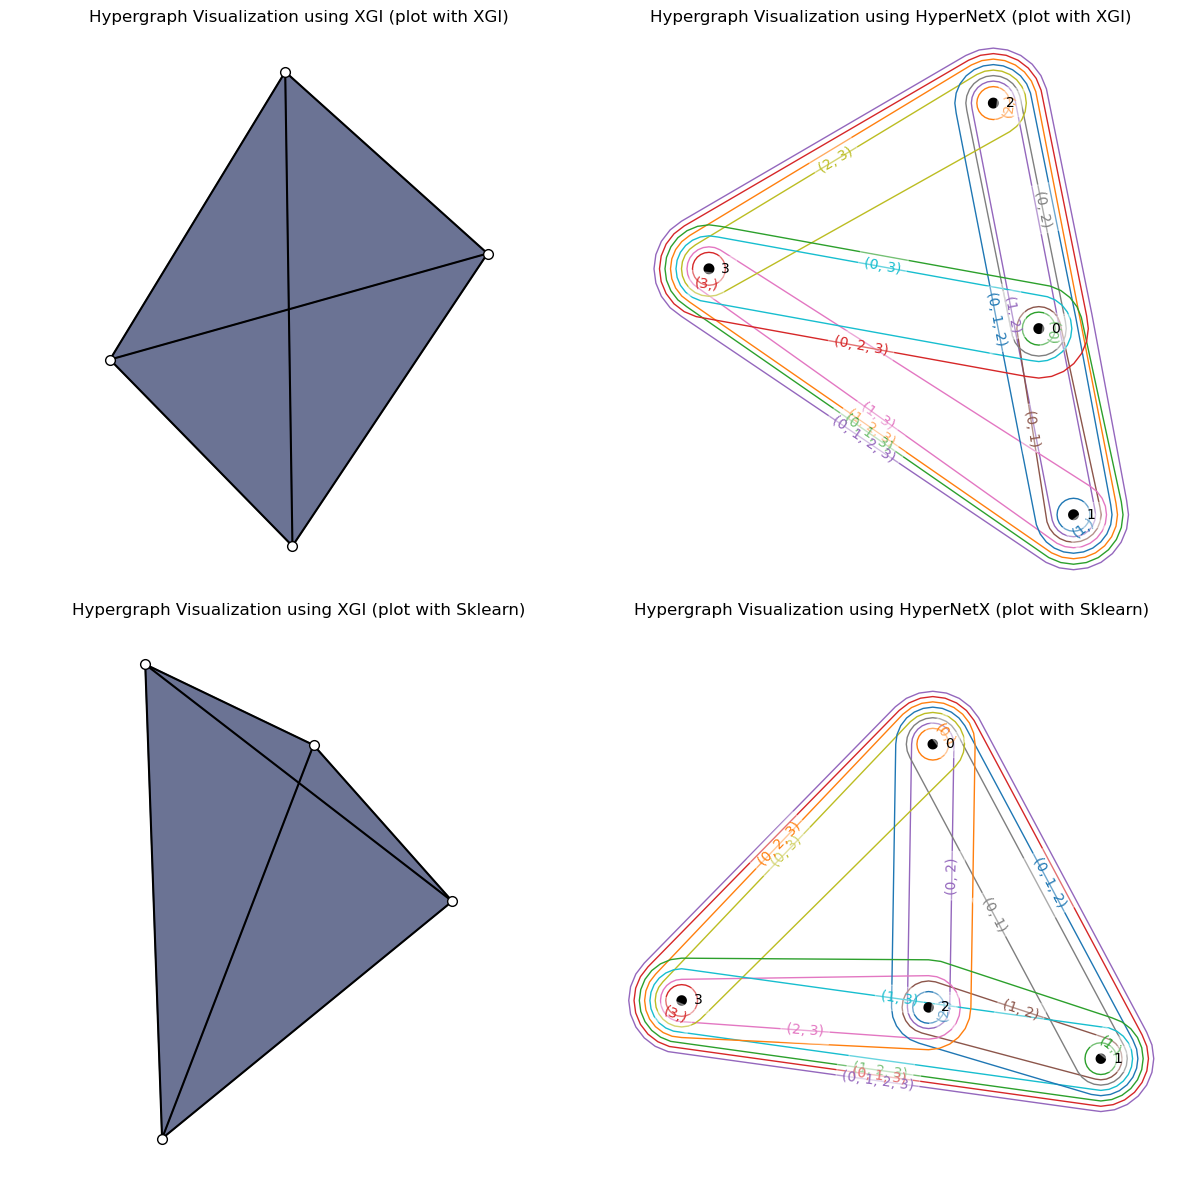

In [58]:
# Define the hypergraph with weights for coarse_hypergraph_xgi and coarse_hypergraph_sklearn
hypergraph_xgi = coarse_hypergraph_xgi
hypergraph_sklearn = coarse_hypergraph_sklearn

# Create an XGI hypergraph for coarse_hypergraph_xgi
xgi_hypergraph_xgi = xgi.Hypergraph()
for edge, weight in hypergraph_xgi.items():
    xgi_hypergraph_xgi.add_edge(edge, weight=weight)

# Convert coarse_hypergraph_xgi to a HyperNetX hypergraph
hnx_hypergraph_xgi = hnx.Hypergraph({str(edge): set(edge) for edge in hypergraph_xgi.keys()})

# Create an XGI hypergraph for coarse_hypergraph_sklearn
xgi_hypergraph_sklearn = xgi.Hypergraph()
for edge, weight in hypergraph_sklearn.items():
    xgi_hypergraph_sklearn.add_edge(edge, weight=weight)

# Convert coarse_hypergraph_sklearn to a HyperNetX hypergraph
hnx_hypergraph_sklearn = hnx.Hypergraph({str(edge): set(edge) for edge in hypergraph_sklearn.keys()})

# Create a figure with 2 rows and 2 columns for four plots
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# Plot the XGI hypergraph for coarse_hypergraph_xgi (top-left)
xgi.draw(xgi_hypergraph_xgi, with_node_labels=True, with_edge_labels=True, edge_labels="weight", ax=ax[0, 0])
ax[0, 0].set_title("Hypergraph Visualization using XGI (plot with XGI)")

# Plot the HyperNetX hypergraph for coarse_hypergraph_xgi (top-right)
hnx.drawing.draw(hnx_hypergraph_xgi, with_edge_labels=True, ax=ax[0, 1])
ax[0, 1].set_title("Hypergraph Visualization using HyperNetX (plot with XGI)")

# Plot the XGI hypergraph for coarse_hypergraph_sklearn (bottom-left)
xgi.draw(xgi_hypergraph_sklearn, with_node_labels=True, with_edge_labels=True, edge_labels="weight", ax=ax[1, 0])
ax[1, 0].set_title("Hypergraph Visualization using XGI (plot with Sklearn)")

# Plot the HyperNetX hypergraph for coarse_hypergraph_sklearn (bottom-right)
hnx.drawing.draw(hnx_hypergraph_sklearn, with_edge_labels=True, ax=ax[1, 1])
ax[1, 1].set_title("Hypergraph Visualization using HyperNetX (plot with Sklearn)")

# Adjust layout for better spacing between the plots
plt.tight_layout()

# Show the figure
plt.show()
